# **BÀI TẬP NHÓM PHÂN TÍCH DỮ LIỆU**
**Thành** **viên**:
1. Ngô Lan Thanh - 050608200640
2. Nguyễn Minh Vy - 050608200782
3. Nguyễn Thanh Vy - 050608200784








# **Câu 1. Spark**

In [90]:
%%capture
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--2023-03-27 19:20:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  42.8MB/s    in 0.3s    

2023-03-27 19:20:06 (42.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [ ]:
def line_to_friend_ownership(line):
    split = line.split()
    user_id = int(split[0])
    if len(split) == 1:
        friends = []
    else:
        friends = list(map(lambda x: int(x), split[1].split(',')))
    return user_id, friends

def friend_ownership_to_connection(f_o):
    user_id = f_o[0]
    friends = f_o[1]
    connections = []
    for friend_id in friends:
        key = (user_id, friend_id)
        if user_id > friend_id:
            key = (friend_id, user_id)
        connections.append((key, 0))  # they are friends, value=0
    for friend_pair in itertools.combinations(friends, 2):
        friend_0 = friend_pair[0]
        friend_1 = friend_pair[1]
        key = (friend_0, friend_1)
        if friend_0 > friend_1:
            key = (friend_1, friend_0)
        connections.append((key, 1))  # they have mutual friends, value=1
    return connections

def mutual_friend_count_to_recommendation(f):
    pair = f[0]
    friend0 = pair[0]
    friend1 = pair[1]
    noMutFriends = f[1]
    rec0 = (friend0, (friend1, noMutFriends))
    rec1 = (friend1, (friend0, noMutFriends))
    return [rec0, rec1]

def recommendation_to_sorted_truncated(recs):
    recs.sort(key=lambda x: (-x[1], x[0]))
    return list(map(lambda x: x[0], recs))[:10]
     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
# create the session
conf = SparkConf().set("spark.ui.port", "4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Read from text file 
lines = sc.textFile("/content/drive/MyDrive/soc-LiveJournal1Adj.txt")

# Map each line to the form: (user_id, [friend_id_0, friend_id_1, ...])
friend_ownership = lines.map(line_to_friend_ownership).filter(lambda friend: '' != friend[1])#.filter(lambda friend: 1000> friend[0]) #take 1000 samples for testing

# Map friend ownerships to instances of ((user_id, friend_id), VALUE).
# VALUE = 0 => pairs are already friends.
# VALUE = 1 => pairs have mutual friends.
friend_edges = friend_ownership.flatMap(friend_ownership_to_connection)
friend_edges.cache()

# Filter pairs that are already friends
mutual_friend = friend_edges.groupByKey() \
    .filter(lambda edge: 0 not in edge[1]) \
    .flatMap(lambda x: [(x[0],item) for item in x[1]]) # flat it to count total mutual friends No; use map directly causes bugs

# Count mutual friends by adding up values
mutual_friend_counts = mutual_friend.reduceByKey( lambda x,y : x+y)

# Create the recommendation objects, group them by key, then sort and 
recommendations = mutual_friend_counts.flatMap(mutual_friend_count_to_recommendation).groupByKey() 

# Truncate the recommendations to the 10 most highly recommended.
recommendations10 = recommendations.map(lambda m: (m[0], recommendation_to_sorted_truncated(list(m[1])))).sortByKey() 

# Include in your writeup the recommendations for the users with following user IDs: 924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993.
results = recommendations10.filter(lambda recommendations: recommendations[0] in [924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
    results.collect()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[(924, [439, 2409, 6995, 11860, 15416, 43748, 45881]),
 (8941, [8943, 8944, 8940]),
 (8942, [8939, 8940, 8943, 8944]),
 (9019, [9022, 317, 9023]),
 (9020, [9021, 9016, 9017, 9022, 317, 9023]),
 (9021, [9020, 9016, 9017, 9022, 317, 9023]),
 (9022, [9019, 9020, 9021, 317, 9016, 9017, 9023]),
 (9990, [13134, 13478, 13877, 34299, 34485, 34642, 37941]),
 (9992, [9987, 9989, 35667, 9991]),
 (9993, [9991, 13134, 13478, 13877, 34299, 34485, 34642, 37941])]

#**Câu 2. Association Rules - Luật kết hợp**

#**(a)** 

Vì bỏ qua Pr(B). Trong một số trường hợp, nó có thể dẫn đến các quy tắc không chính xác. Ví dụ: sự xuất hiện của B có thể không liên quan đến A (ví dụ: A và B độc lập, sao cho conf(A→B) = Pr(B|A) = Pr(B)) nhưng B có độ hỗ trợ cao, do đó A→ B được xác định là một quy tắc hợp lệ. Bằng cách quan sát các công thức, chúng ta có thể thấy rằng lượt chuyển đổi và mức tăng có tính đến Pr(B).


# **(b)** 

Trong các chỉ tiêu được giới thiệu ở đây, chỉ số tăng trưởng (lift) là không đối xứng.

lift(A→B) = lift(B→A) = Pr(A,B)/Pr(A).Pr(B)

conf(A→B) = Pr(B|A)and conf(B→A) = Pr(A|B).Pr(A|B)and Pr(B|A)có thể khác nhau.
Conv dựa trên conf và có tính định hướng.

Ví dụ: Nếu chúng ta chọn lọc thành các nhóm AB, AC, AD thì S(A) = 3/3, S(B) = 1/3 và Pr(A, B) = 1/3. Khi đó conf(A→B) =Pr(B|A)6= Pr(A|B)= conf(B→A) kể từ: (1/3)/(3/3) khác (1/3)/(1/3).
Tương tự, conv(A→B)= (1−S(B))/(1−conf(A→B)) khác (1−S(A))/(1−conf(B→A)) khác conv(B→A) vì: (1−1/3)/(1−1/2) khác 4/3 khác (1− 2/3)/(1−1) = inf. 

Cụ thể hơn thì: 
For Lift(A → B), ta có: 

Lift(A → B) = Conf(A → B) / S(B)

                     = Pr( A ⋂ B) / (Pr(A) * Pr(B))
                     = Pr ( B ⋂ A) / (Pr(B) * Pr(A))
                     = Lift(B → A)
For Conviction(A → B), ta có:

Conviction(A → B) = (1 - S(B)) / (1- Conf(A → B))

                                 = (1 - Pr(B)) / (1 Pr(A ⋂ B) / (Pr(A)))
                                 = Pr(not B) / (Pr (A ⋂ not B) / (Pr(A)))

# **(c)** 

Chỉ tiêu tăng trưởng (lift) và chỉ số thuyết phục (conviction) đều có tính chất này vì cả hai chỉ tiêu đạt giá trị tối đa của chúng cho tất cả các liên hệ hoàn hảo (perfect implications). Nếu B xảy ra mỗi khi A xảy ra (nghĩa là Pr(B|A) = 1) thì: 

> conf(A→B) = 1

> conv(A→B) → vô cùng

> lift(A→B) phụ thuộc vào giá trị của Pr(B) và có thể khác nhau vì B có thể xảy ra trong các phần tử chọn lọc không có A. 

Ví dụ: Nếu chúng ta có các phần tử chọn lọc AB, AB, CD, EF thì Pr(B|A) = 1,S(B) = 1/2, Pr(D|C) = 1, và S(D) = 1/4 .Sau đó, lift(A→B) = 1/(1/2) = 2 và lift(C→D) = 1/(1/4) = 4. Mặc dù cả hai quy tắc đều là quy tắc 100% nhưng chúng có điểm số mức tăng khác nhau.




#**(d)**

In [ ]:
# Importing libraries
from collections import defaultdict
from itertools import combinations
from operator import itemgetter

In [ ]:
# Load dataset and remove duplicates
data = []
with open('/content/browsing.txt', 'r') as f:
    for line in f:
        items = set(line.strip().split())
        data.append(list(items))

In [ ]:
# First pass to find frequent items
min_support = 100 # define minimum support
item_counts = defaultdict(int)
for basket in data:
    for item in basket:
        item_counts[item] += 1
frequent_items = set(item for item, count in item_counts.items() if count >= min_support)

In [ ]:
# Second pass to find frequent itemsets of size 2
itemset_counts = defaultdict(int)
for basket in data:
    for itemset in combinations(basket, 2):
        if set(itemset).issubset(frequent_items):
            itemset_counts[itemset] += 1
frequent_itemsets = set(itemset for itemset, count in itemset_counts.items() if count >= min_support)

In [ ]:
# Generate association rules for pairs of items
rules = []
for itemset in frequent_itemsets:
    for item in itemset:
        antecedent = frozenset([item])
        consequent = frozenset(frozenset(itemset) - antecedent)
        confidence = itemset_counts[itemset] / item_counts[item]
        rules.append((antecedent, consequent, confidence))

In [ ]:
# Sort rules by confidence and print top 5
top_rules = sorted(rules, key=lambda x: (-x[2], tuple(x[0])))
for antecedent, consequent, confidence in top_rules[:5]:
    print(f"{tuple(antecedent)} -> {tuple(consequent)} : {confidence}")


('GRO85051',) -> ('FRO40251',) : 0.9942339373970346
('GRO38636',) -> ('FRO40251',) : 0.9813084112149533
('ELE12951',) -> ('FRO40251',) : 0.9811320754716981
('DAI43868',) -> ('SNA82528',) : 0.972972972972973
('DAI23334',) -> ('DAI62779',) : 0.9545454545454546


# **(e)**

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=33943611d28c90626cdfec2b287da32c2f27c147e8b7ae3c9c93934ac91897e7
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
import itertools
import pyspark

In [ ]:
sc=pyspark.SparkContext("local","Apriori")
# Load data from a text file
text_input = sc.textFile('/content/browsing.txt')

In [ ]:
# The total number of baskets in the dataset
from operator import add
no_of_baskets = text_input.map(lambda line: line.split()).count()
no_of_baskets

31101

In [ ]:
txt_RDD = text_input.map(lambda line:line.split())


In [ ]:
# Check the output of the previous transformations
individual_counts = text_input.flatMap(lambda line: line.split()).map(lambda x: (x,1)).reduceByKey(add)
individual_counts.take(5)
# Sort items in RDD
freq_items_counts = individual_counts.filter(lambda x: x[1]>=100).sortBy(lambda x: x[0])
freq_items_counts.take(5)
freq_items_counts_list = individual_counts.filter(lambda x: x[1]>=100).sortBy(lambda x: x[0]).collect()
#Retrieve the first 5 items in the RDD
freq_items = freq_items_counts.map(lambda x: x[0])
freq_items.take(5)

['DAI11223', 'DAI11778', 'DAI13194', 'DAI13266', 'DAI13788']

In [ ]:
freq_items_list = freq_items_counts.map(lambda x: x[0]).collect()
freq_items_list[:5]

['DAI11223', 'DAI11778', 'DAI13194', 'DAI13266', 'DAI13788']

In [ ]:
# A variable that stores the total number of frequent items in the dataset.
no_of_freq_items=freq_items.count()
no_of_freq_items

647

In [ ]:
# List containing both tuples, which represent the confidence scores of the two association rules for the item pair (X, Y) - 1st
def filter_and_pair(lst):
    ret=[]
    pairs=[]
    for i in lst:
        if i in freq_items_list:
            ret.append(i)
    ret.sort()
    for pair in itertools.combinations(ret,2):
        pairs.append((pair,1))
    return(pairs)
def confidence(elem):
    lst=[]
    conf1 = elem[1]/(freq_pair_counts.filter(lambda x: x[0]==elem[0][0]).collect())[0][1]
    conf2 = elem[1]/(freq_items_counts.filter(lambda x: x[0]==elem[0][1]).collect())[0][1]
    lst.append(((elem[0],elem[1]),conf1))
    lst.append(((elem[1],elem[0]),conf2))
    return(lst)

In [ ]:
# List containing both tuples, which represent the confidence scores of the two association rules for the item pair (X, Y) - 2nd
def filter_2(lst):
    ret=[]
    trips=[]
    for i in lst:
        if i in freq_items_2:
            ret.append(i)
    ret.sort()
    for trip in itertools.combinations(ret,3):
        trips.append(((trip),1))
    return(trips)
def confidence2(elem):
    lii=[]
    for i in (itertools.combinations(elem[0],2)):
        conf=elem[1]/(freq_pair_counts.filter(lambda X: x[0]==i)).collect[0][1]
        lii.append((i,conf))
    ret(lii)

In [ ]:
pair_counts = txt_RDD.flatMap(lambda x: filter_and_pair(x)).reduceByKey(add).sortBy( lambda x: x[0])
pair_counts.take(5)

[(('DAI11223', 'DAI13194'), 1),
 (('DAI11223', 'DAI13266'), 1),
 (('DAI11223', 'DAI13902'), 2),
 (('DAI11223', 'DAI20585'), 1),
 (('DAI11223', 'DAI22177'), 17)]

In [ ]:
freq_pair_counts = pair_counts.filter(lambda x: x[1]>=100)
freq_pair_counts.take(5)
freq_pair_counts_list = freq_pair_counts.collect()
freq_pair_counts_list[:5]

[(('DAI16732', 'FRO78087'), 106),
 (('DAI18527', 'SNA44451'), 102),
 (('DAI22177', 'DAI31081'), 127),
 (('DAI22177', 'DAI62779'), 382),
 (('DAI22177', 'DAI63921'), 136)]

In [ ]:
freq_pairs = freq_pair_counts.map(lambda x: x[0])
freq_pairs.take(5)

[('DAI16732', 'FRO78087'),
 ('DAI18527', 'SNA44451'),
 ('DAI22177', 'DAI31081'),
 ('DAI22177', 'DAI62779'),
 ('DAI22177', 'DAI63921')]

In [ ]:
conf_lst=[]
for i in freq_pair_counts_list:
    conf1 = i[1]/(freq_items_counts.filter(lambda x: x[0]==i[0][0]).collect())[0][1]
    conf2 = i[1]/(freq_items_counts.filter(lambda x: x[0]==i[0][1]).collect())[0][1]
    conf_lst.append(((i[0][0],i[0][1]),conf1))
    conf_lst.append(((i[0][1],i[0][0]),conf2))

In [ ]:
conf_lst.sort(key=lambda x: -x[1])


In [ ]:
freq_items_2 = freq_pairs.flatMap(lambda x: x).collect()
freq_items_2[:5]

['DAI16732', 'FRO78087', 'DAI18527', 'SNA44451', 'DAI22177']

In [ ]:
trips_counts = txt_RDD.flatMap(lambda x: filter_2(x)).reduceByKey(add).sortBy(lambda x: x[0])
trips_counts.take(5)

[(('DAI16732', 'DAI18527', 'DAI35347'), 2),
 (('DAI16732', 'DAI18527', 'DAI59508'), 2),
 (('DAI16732', 'DAI18527', 'DAI62779'), 1),
 (('DAI16732', 'DAI18527', 'DAI63921'), 2),
 (('DAI16732', 'DAI18527', 'DAI85309'), 1)]

In [ ]:
freq_trips = trips_counts.filter(lambda x: x[1]>=100)
freq_trips.take(5)

[(('DAI22896', 'DAI62779', 'GRO73461'), 101),
 (('DAI23334', 'DAI62779', 'ELE92920'), 143),
 (('DAI31081', 'DAI62779', 'ELE17451'), 103),
 (('DAI31081', 'DAI75645', 'FRO40251'), 122),
 (('DAI31081', 'ELE32164', 'GRO59710'), 112)]

In [ ]:
freq_trips_list = trips_counts.filter(lambda x: x[1]>=100).collect()
conf_trips=[]
for i in freq_trips_list:
    a=set(i[0])
    for j in (itertools.combinations(i[0],2)):
        b=set(j)
        c=list(a-b)
        conf=i[1]/(freq_pair_counts.filter(lambda x: x[0]==j)).collect()[0][1]
        conf_trips.append(((j,c[0]),conf))

In [ ]:
conf_trips.sort(key = lambda x: -x[1])
conf_trips[:5]

[((('DAI23334', 'ELE92920'), 'DAI62779'), 1.0),
 ((('DAI31081', 'GRO85051'), 'FRO40251'), 1.0),
 ((('DAI55911', 'GRO85051'), 'FRO40251'), 1.0),
 ((('DAI62779', 'DAI88079'), 'FRO40251'), 1.0),
 ((('DAI75645', 'GRO85051'), 'FRO40251'), 1.0)]

# **Câu 3: Locality-Sensitive Hashing - Tìm các văn bản tương đồng dựa vào chuỗi số định danh**


#**(a)** 
Số cột có m số 1 trong tổng số n cột là (n/m) . Số cột không có số 1 nào trong k hàng được chọn là (n-k/m). Xác suất không có số 1 trong k hàng đã chọn là tỷ lệ giữa hai số trên. 

Nếu ta mở rộng hệ số nhị thức thành giai thừa, ta sẽ được ((n-k)!m!(n-m)!)/(m!(n-k-m)!n!). 

Các giai thừa của m! bị rút gọn và khi ta tái tổ chức, ta có thể viết biểu thức này thành (n-k/n).((n-k-1)/(n-1))...((n-k-m+1)/(n-m+1)). Mỗi yếu tố trong m có nhiều nhất (n-k)/n. 

> Do đó, tích của chúng không vượt quá ((n-k)/n)^m

#**(b)** 

Chúng ta muốn ((n-k)/n)^m =< e^(-10). Tương đương với (1 - (k/n) ^ (n/k) < e^(-10). Nếu nhân và chia mũ số mũ cho n/k, ta sẽ thấy điều kiện này tương đương với ((1-(k/n)^(n/k))^(mk/n) =< e^(-10). 

Vì chúng ta giả định k << n, chúng ta có thể xấp xỉ bằng (1-(k/n)^(n/k) by 1/e. 

> Điều đó làm cho điều kiện mong muốn trở thành e^(-mk/n) =< e^(-10). 

> Do đó, số mũ đầu tiên phải nhỏ hơn hoặc bằng số mũ thứ hai; tức là -mk/n =< -10, hoặc (mk/n) >= 10. Điều đó lại có nghĩa là k >= 10n/m, vì vậy câu trả lời chính xác, giới hạn dưới của k, là 10n/m.

#**(c)** 

Độ tương đồng Jaccard và kỹ thuật minhash trong bối cảnh hai tập hợp được đại diện bởi hai cột [0, 1, 0]T và [0, 1, 1]T. Độ tương đồng Jaccard giữa hai tập hợp này được tính là 0,5.

Tuy nhiên, khi sử dụng minhashing với các hoán vị tuần hoàn, giá trị minhash sẽ khác nhau tùy thuộc vào hàng nào bắt đầu chu trình. Nếu chu trình bắt đầu từ bất kỳ trong hai hàng đầu tiên, giá trị minhash sẽ giống nhau. Nhưng nếu chu trình bắt đầu từ hàng cuối cùng, giá trị minhash sẽ khác nhau.

Do đó, xác suất các giá trị minhash giống nhau là 2/3 khi chỉ cho phép các hoán vị tuần hoàn. Điều này có nghĩa là nếu các giá trị minhash được sử dụng để so sánh các tập hợp, xác suất nhận được kết quả dương tính sai là 1/3, tức là khá cao. Do đó, khi sử dụng minhashing với các hoán vị tuần hoàn, quan trọng là phải cân nhắc xác suất này và áp dụng các biện pháp thích hợp để giảm thiểu các kết quả dương tính sai, chẳng hạn như tăng số lượng hàm băm hoặc sử dụng các kỹ thuật khác như locality-sensitive hashing.

> Đặt A= {1,2,3}, B= {4,5,6},C = {3,4,5,6}. Có sim(A,B) = 0, sim(B,C)= 3/3.5, sim(A,C)=1/3.5

#Vì vậy

> **D(A,B)= 1-0=1, D(B,C)= 1- 0.857=0.14, D(A,C)=1-0.286=0.71**

> **D(A,B)= 1>0.85=D(B,C)+D(A,C)**


# **Question 4. LSH for Approximate Near Neighbor Search**


#**(a)**
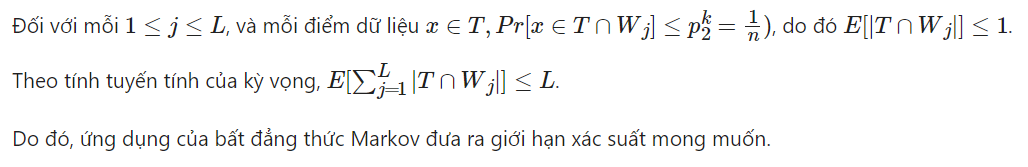

#**(b)**

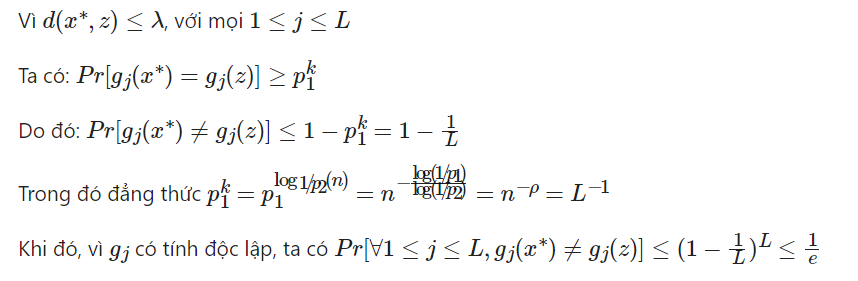

#**(c)**

Hãy ký hiệu bởi U tập hợp các điểm ANN, nghĩa là U={x∈ A;d(x, z)6cλ}. Lưu ý rằng x∗∈U. Có hai cách để một điểm được báo cáo không phải là (c, λ)-ANN:

- Không có điểm ANN nào được băm vào các thùng giống như z, tức là ∀1≤j≤L, Wj∩U=∅. Hãy ký hiệu bởi E sự kiện "không có điểm ANN nào được băm vào các thùng giống như z". Vì x∗∈U, chúng ta có, sử dụng câu hỏi (b): 

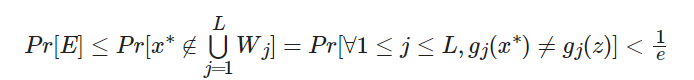

- Hoặc có ít nhất một điểm (c, λ)-ANN được băm vào một trong các thùng mà z được băm vào, nhưng có nhiều hơn 3L điểm ở khoảng cách lớn hơn cλ trong tổng các thùng đó. (Nếu có ít hơn 3L điểm ở khoảng cách lớn hơn cλ trong SLj=1 Wj, thuật toán sẽ trả về một (c, λ)-ANN.) Hãy ký hiệu bởi F sự kiện "có hơn 3L điểm ở khoảng cách lớn hơn cλ từ z trong tổng các thùng mà z được băm vào". Trong trường hợp đó, chúng ta có thể áp dụng câu hỏi (a) và chúng ta biết rằng sự kiện F xuất hiện với xác suất nhỏ hơn 1/3.

> Lưu ý rằng phủ định của sự kiện "PLj=1 |T∩Wj|>3L" chỉ nói rằng có ít hơn 3L điểm không phải ANN trong SLj=1 Wj (hãy ký hiệu bởi m số lượng các điểm không phải ANN trong tổng này). Nó không nói rằng tồn tại điểm thứ m+ 1 trong tổng này (lưu ý rằng sự tồn tại của nó sẽ đảm bảo rằng chúng ta có thể tìm thấy một (c, λ)-ANN). Đó là lý do tại sao câu hỏi (a) không đủ để trả lời câu hỏi (c) trong trường hợp có ít hơn 3L điểm trong SLj=1 Wj, và chúng ta cũng cần câu hỏi (b).

Vậy, nếu chúng ta đặt ¯p là xác suất mà điểm được trả về bởi thuật toán không phải là (c, λ)-ANN, thì ta có 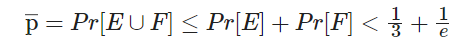 (bằng phương pháp liên hiệp), và vì vậy thuật toán luôn báo cáo một (c, λ)-ANN thực tế với xác suất lớn hơn 1- 1/3 - 1/e. 

Chú ý: Chúng ta chưa chỉ ra rằng các sự kiện E và F độc lập, vì vậy sẽ không chính xác nếu nói Pr[E∩F] = Pr[E]·Pr[F]. Có thể định nghĩa các sự kiện tương tự E và F và chứng minh rằng chúng độc lập, và **làm như vậy sẽ đưa ra một xác suất độ chính xác lớn hơn so với sử dụng phương pháp liên hiệp.**

In [83]:
from lsh import *
import time
from tabulate import tabulate
import matplotlib.pyplot as plt

In [85]:
# Load the dataset
A = load_data('/content/drive/MyDrive/patches.csv')
#A = load_data('patches.csv')
print("Data shape: {}".format(A.shape))


Data shape: (59500, 400)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
# Set parameters
L = 10
k = 24
num_neighbors = 3

# Define query points
query_indices = range(100, 1100, 100)
print("Query points: {}".format([i for i in query_indices]))

Query points: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


In [87]:
# Run LSH setup
functions, hashed_A = lsh_setup(A, k=k, L=L)

In [ ]:
# Perform LSH and linear search
lsh_search_times = [] # Time taken to run LSH search
linear_search_times = [] # Time taken to run linear search
lsh_neighbors_list = [] # List of LSH neighbors
linear_neighbors_list = [] # List of linear neighbors

for query_index in query_indices:
    # Run LSH search
    start_time = time.time()
    lsh_neighbors = lsh_search(A, hashed_A, functions, query_index, num_neighbors=num_neighbors)
    lsh_neighbors_list.append(lsh_neighbors)
    lsh_search_times.append(time.time() - start_time)
    
    # Run linear search
    start_time = time.time()
    linear_neighbors = linear_search(A, query_index, num_neighbors=num_neighbors)
    linear_neighbors_list.append(linear_neighbors)
    linear_search_times.append(time.time() - start_time)

In [ ]:
# Print results
print("LSH Average Search Time: {:.4f} seconds".format(np.mean(lsh_search_times)))
print("Linear Average Search Time: {:.4f} seconds".format(np.mean(linear_search_times)))

headers = ['Query Index', 'LSH Neighbors', 'Linear Neighbors']
table = []
for i in range(len(query_indices)):
    table.append([query_indices[i], 
                  ", ".join(map(str, lsh_neighbors_list[i])), 
                  ", ".join(map(str, linear_neighbors_list[i]))])

print("Top 3 Neighbors for Each Query Point:")
print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

In [ ]:
# Define list of L values and k values to test
case_1 = {
    "L": [i for i in range(10, 22, 2)], 
    "k": [24]}
case_2 = {
    "L": [10],
    "k": [i for i in range(16, 26, 2)]}

In [ ]:
def errors_evaluation(A, query_indices, num_neighbors, case):
    L_list, k_list = case["L"], case["k"]
    errors = []
    for L in L_list:
        for k in k_list:
            functions, hashed_A = lsh_setup(A, k=k, L=L)
            # Perform LSH search
            lsh_neighbors_list = []
            for query_index in query_indices:
                lsh_neighbors = lsh_search(A, hashed_A, functions, query_index, num_neighbors=num_neighbors)
                lsh_neighbors_list.append(lsh_neighbors)
            
            # Perform linear search
            linear_neighbors_list = []
            for query_index in query_indices:
                linear_neighbors = linear_search(A, query_index, num_neighbors=num_neighbors)
                linear_neighbors_list.append(linear_neighbors)
            
            # Calculate error
            error = 0
            for i in range(len(query_indices)):
                lsh_neighbors = lsh_neighbors_list[i]
                linear_neighbors = linear_neighbors_list[i]
                query_index = query_indices[i]
                error = error_measure(A, query_index, linear_neighbors, lsh_neighbors)
                error += error
            error = error / len(query_indices)
            errors.append((L, k, error))
    
    return errors

In [ ]:
%%time
case_1_errors = errors_evaluation(A, query_indices, num_neighbors, case_1)

# Print errors for case 1
print("Case 1 Errors:")
for L, k, error in case_1_errors:
    print("(L: {}, k: {}) -> Error: {:.4f}".format(L, k, error))

In [ ]:
%%time
case_2_errors = errors_evaluation(A, query_indices, num_neighbors, case_2)

# Print errors for case 2
print("Case 2 Errors:")
for L, k, error in case_2_errors:
    print("(L: {}, k: {}) -> Error: {:.4f}".format(L, k, error))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot case 1
L_list_1 = case_1["L"]
k_1 = case_1["k"][0]
errors_1 = [error for _, _, error in case_1_errors]
ax[0].plot(L_list_1, errors_1) 

# Plot case 2
k_list_2 = case_2["k"]
L_2 = case_2["L"][0]
errors_2 = [error for _, _, error in case_2_errors]
ax[1].plot(k_list_2, errors_2)

ax[0].set_title("Case 1: Error values as a function of L")
ax[0].set_xlabel("L")
ax[0].set_ylabel("Error")

ax[1].set_title("Case 2: Error values as a function of k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Error")

plt.show()

In [ ]:
# Define parameters
L = 24
k = 24
num_neighbors = 10
query_index = 100

# Run setup
functions, hashed_A = lsh_setup(A, k=k, L=L)

# Run LSH search
lsh_neighbors = lsh_search(A, hashed_A, functions, query_index, num_neighbors=num_neighbors)

# Run linear search
linear_neighbors = linear_search(A, query_index, num_neighbors=num_neighbors)


In [ ]:
# Plot original image
plot(A, row_nums=[query_index], base_filename="original", output_path="image_output/")


In [ ]:
# Plot LSH neighbors
plot(A, 
     row_nums=lsh_neighbors, 
     base_filename="lsh_neighbors", 
     output_path="image_output/lsh/", 
     grid_size=(2, 5), title="Top 10 LSH Neighbors")

In [ ]:
# Plot linear neighbors
plot(A, 
     row_nums=linear_neighbors, 
     base_filename="linear_neighbors", 
     output_path="image_output/linear/", 
     grid_size=(2, 5), 
     title="Top 10 Linear Neighbors")